# Implementing Ensemble Learning for Improved Accuracy and Results
In this approach, we leverage the strengths of our top-performing models—UNETR, SegResNet, and DynUNet—by combining them into an ensemble to enhance the segmentation of wrist bones. This ensemble method aims to achieve superior segmentation accuracy and more robust results by capitalizing on the unique strengths of each model.

### Importing Necessary Libraries

In [1]:
import torch
from monai.networks.nets import SegResNet, DynUNet, UNETR
from monai.transforms import Compose, LoadImaged, AddChanneld, ScaleIntensityRanged, EnsureTyped, ToTensord,NormalizeIntensityd
from monai.data import Dataset, DataLoader,decollate_batch
from monai.inferers import sliding_window_inference
from monai.transforms import Compose, Activations, AsDiscrete
from monai.metrics import DiceMetric
from monai.transforms import AsDiscrete
from glob import glob
import os
import numpy as np
import torch
from monai.metrics import SurfaceDistanceMetric
from monai.inferers import sliding_window_inference
from monai.data import decollate_batch
from monai.transforms import Compose, Activations, AsDiscrete
import matplotlib.pyplot as plt
import nibabel as nib
from matplotlib import colors

### Defining Model Architectures

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# SegResNet Model
segresnet_model = SegResNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=11,
    init_filters=16,
    dropout_prob=0.2,
    norm='batch'
).to(device)  

# Loading state dictionary
segresnet_model.load_state_dict(torch.load('best_metric_model_segresnet.pth', map_location=device))
segresnet_model.eval()

# DynUNet Model
dynunet_model = DynUNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=11,  # 10 bones + background
    kernel_size=[3, 3, 3, 3],  
    strides=[1, 2, 2, 2], 
    upsample_kernel_size=[2, 2, 2],  
    norm_name="instance",
    deep_supervision=False,
    res_block=True,
).to(device) 

# Loading state dictionary
dynunet_model.load_state_dict(torch.load('best_metric_model_dyunet.pth', map_location=device))
dynunet_model.eval()

# UNETR Model
unetr_model = UNETR(
    in_channels=1,
    out_channels=11,  # 10 bones + background
    img_size=(128, 128, 48),
    feature_size=32,
    hidden_size=384,
    mlp_dim=1024,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.1 
).to(device)  

# Loading state dictionary
unetr_model.load_state_dict(torch.load('best_metric_model_unetr.pth', map_location=device))
unetr_model.eval()


UNETR(
  (vit): ViT(
    (patch_embedding): PatchEmbeddingBlock(
      (patch_embeddings): Sequential(
        (0): Rearrange('b c (h p1) (w p2) (d p3) -> b (h w d) (p1 p2 p3 c)', p1=16, p2=16, p3=16)
        (1): Linear(in_features=4096, out_features=384, bias=True)
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (blocks): ModuleList(
      (0-11): 12 x TransformerBlock(
        (mlp): MLPBlock(
          (linear1): Linear(in_features=384, out_features=1024, bias=True)
          (linear2): Linear(in_features=1024, out_features=384, bias=True)
          (fn): GELU(approximate='none')
          (drop1): Dropout(p=0.1, inplace=False)
          (drop2): Dropout(p=0.1, inplace=False)
        )
        (norm1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
        (attn): SABlock(
          (out_proj): Linear(in_features=384, out_features=384, bias=True)
          (qkv): Linear(in_features=384, out_features=1152, bias=False)
          (input_rearrange): Rearrange('b

### Data Loaders and Data Transformation

In [3]:
val_transforms = Compose([
    LoadImaged(keys=['image', 'label']),
    AddChanneld(keys=['image', 'label']),
    NormalizeIntensityd(keys=['image'], nonzero=True, channel_wise=True),
    ScaleIntensityRanged(keys=['image'], a_min=0.0011, a_max=1.01, b_min=0.0, b_max=1.0, clip=True),
    EnsureTyped(keys=['image', 'label']),
    ToTensord(keys=['image', 'label'])
])

In [4]:
data_dir = '/workspace/data'

train_images = sorted(glob(os.path.join(data_dir, 'imagesTr', '*nii.gz')))
train_labels = sorted(glob(os.path.join(data_dir, 'labelsTr', '*nii.gz')))

val_images = sorted(glob(os.path.join(data_dir, 'imagesTs', '*nii.gz')))
val_labels = sorted(glob(os.path.join(data_dir, 'labelsTs', '*nii.gz')))

train_files = [{"image": image_name, 'label': label_name} for image_name, label_name in zip(train_images, train_labels)]
val_files = [{"image": image_name, 'label': label_name} for image_name, label_name in zip(val_images, val_labels)]

In [5]:
# Creating datasets and dataloaders
val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False)

### Evaluation of the Model
In this section, we evaluate the ensemble model's performance by calculating the Dice metric and Average Symmetric Surface Distance (ASSD) for each of the 10 wrist bones. These metrics provide insights into the segmentation accuracy and spatial agreement between predicted and actual bone structures.

### 1. Dice Metric Calculation

In [24]:
# Defining metrics and transformations
dice_metric_batch = DiceMetric(include_background=True, reduction="none")
post_pred = Compose([Activations(softmax=True), AsDiscrete(argmax=True, to_onehot=11)])
post_label = Compose([AsDiscrete(to_onehot=11)])

# Function to calculate the mean and standard deviation of dice scores
def calculate_mean_std(dice_scores):
    mean_dice = torch.mean(dice_scores, dim=0)
    std_dice = torch.std(dice_scores, dim=0)
    return mean_dice, std_dice

# Ensemble Inference and Dice Calculation
all_dice_scores = []

with torch.no_grad():
    for batch_data in val_loader:
        inputs = batch_data["image"].to(device)
        labels = batch_data["label"].to(device)

        # Getting predictions from each model
        segresnet_output = sliding_window_inference(inputs, (128, 128, 48), 4, segresnet_model)
        dynunet_output = sliding_window_inference(inputs, (128, 128, 48), 4, dynunet_model)
        unetr_output = sliding_window_inference(inputs, (128, 128, 48), 4, unetr_model)

        # Averaging the predictions
        combined_output = (segresnet_output + dynunet_output + unetr_output) / 3.0

        # Post-processing the predictions
        val_outputs = [post_pred(i) for i in decollate_batch(combined_output)]
        val_labels = [post_label(i) for i in decollate_batch(labels)]

        # Calculating Dice score for each batch
        dice_metric_batch(y_pred=val_outputs, y=val_labels)

        # Storing dice scores for the current batch
        batch_dice_scores = dice_metric_batch.aggregate().cpu()
        all_dice_scores.append(batch_dice_scores)

        # Reseting for the next batch
        dice_metric_batch.reset()


all_dice_scores = torch.cat(all_dice_scores, dim=0)


mean_dice, std_dice = calculate_mean_std(all_dice_scores)


print("Final per-class Dice metrics:")
for i, (mean, std) in enumerate(zip(mean_dice, std_dice)):
    print(f"Class {i} dice: {mean.item():.4f} +/- {std.item():.4f}")

Final per-class Dice metrics:
Class 0 dice: 0.9913 +/- 0.0016
Class 1 dice: 0.8592 +/- 0.0649
Class 2 dice: 0.9271 +/- 0.0169
Class 3 dice: 0.8934 +/- 0.0349
Class 4 dice: 0.8974 +/- 0.0388
Class 5 dice: 0.8696 +/- 0.0345
Class 6 dice: 0.9166 +/- 0.0275
Class 7 dice: 0.8862 +/- 0.0352
Class 8 dice: 0.9288 +/- 0.0160
Class 9 dice: 0.8231 +/- 0.1025
Class 10 dice: 0.8699 +/- 0.0232


### 2. Average Symmetric Surface Distance (ASSD)

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


segresnet_model = SegResNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=11,
    init_filters=16,
    dropout_prob=0.2,
    norm='batch'
).to(device)
segresnet_model.load_state_dict(torch.load('best_metric_model_segresnet.pth', map_location=device))
segresnet_model.eval()

dynunet_model = DynUNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=11,  # 10 bones + background
    kernel_size=[3, 3, 3, 3],
    strides=[1, 2, 2, 2],
    upsample_kernel_size=[2, 2, 2],
    norm_name="instance",
    deep_supervision=False,
    res_block=True,
).to(device)
dynunet_model.load_state_dict(torch.load('best_metric_model_dyunet.pth', map_location=device))
dynunet_model.eval()

unetr_model = UNETR(
    in_channels=1,
    out_channels=11,  # 10 bones + background
    img_size=(128, 128, 48),
    feature_size=32,
    hidden_size=384,
    mlp_dim=1024,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.1
).to(device)
unetr_model.load_state_dict(torch.load('best_metric_model_unetr.pth', map_location=device))
unetr_model.eval()

# Defining metric and transformations
surface_distance_metric_batch = SurfaceDistanceMetric(include_background=False, reduction="none")
post_pred = Compose([Activations(softmax=True), AsDiscrete(argmax=True, to_onehot=11)])
post_label = Compose([AsDiscrete(to_onehot=11)])

# Function to calculate the mean and standard deviation of ASSD scores
def calculate_mean_std(metric_scores):
    mean_metric = torch.mean(metric_scores, dim=0)
    std_metric = torch.std(metric_scores, dim=0)
    return mean_metric, std_metric

# Ensemble Inference and ASSD Calculation
all_assd_scores = []

with torch.no_grad():
    for batch_data in val_loader:
        inputs = batch_data["image"].to(device)
        labels = batch_data["label"].to(device)

        # Getting predictions from each model
        segresnet_output = sliding_window_inference(inputs, (128, 128, 48), 4, segresnet_model)
        dynunet_output = sliding_window_inference(inputs, (128, 128, 48), 4, dynunet_model)
        unetr_output = sliding_window_inference(inputs, (128, 128, 48), 4, unetr_model)

        # Averaging the predictions
        combined_output = (segresnet_output + dynunet_output + unetr_output) / 3.0

        # Post-processing the predictions
        val_outputs = [post_pred(i) for i in decollate_batch(combined_output)]
        val_labels = [post_label(i) for i in decollate_batch(labels)]

        # Calculating ASSD for each batch
        surface_distance_metric_batch(y_pred=val_outputs, y=val_labels)

        # Storing ASSD scores for the current batch
        batch_assd_scores = surface_distance_metric_batch.aggregate().cpu()
        all_assd_scores.append(batch_assd_scores)

        # Resetting for the next batch
        surface_distance_metric_batch.reset()


all_assd_scores = torch.cat(all_assd_scores, dim=0)

# Calculating mean and standard deviation
mean_assd, std_assd = calculate_mean_std(all_assd_scores)

# Printing per-class ASSD metrics
print("Final per-class ASSD metrics:")
for i, (mean, std) in enumerate(zip(mean_assd, std_assd)):
    print(f"Class {i} ASSD: {mean.item():.4f} +/- {std.item():.4f}")

Final per-class ASSD metrics:
Class 0 ASSD: 1.0297 +/- 0.4662
Class 1 ASSD: 0.6909 +/- 0.1566
Class 2 ASSD: 0.5727 +/- 0.1112
Class 3 ASSD: 0.6120 +/- 0.1849
Class 4 ASSD: 0.6419 +/- 0.2028
Class 5 ASSD: 0.5346 +/- 0.1728
Class 6 ASSD: 0.5821 +/- 0.1227
Class 7 ASSD: 0.5151 +/- 0.1195
Class 8 ASSD: 0.8164 +/- 0.3530
Class 9 ASSD: 0.6121 +/- 0.1210


### Data Visualization
In this section, we visualize the predicted segmentation masks of the wrist bones. We display all the bones together and also visualize each bone individually to better understand the segmentation output and evaluate the accuracy of each predicted structure.

Test output shape: (1, 1, 128, 128, 48)
Unique values in test output: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


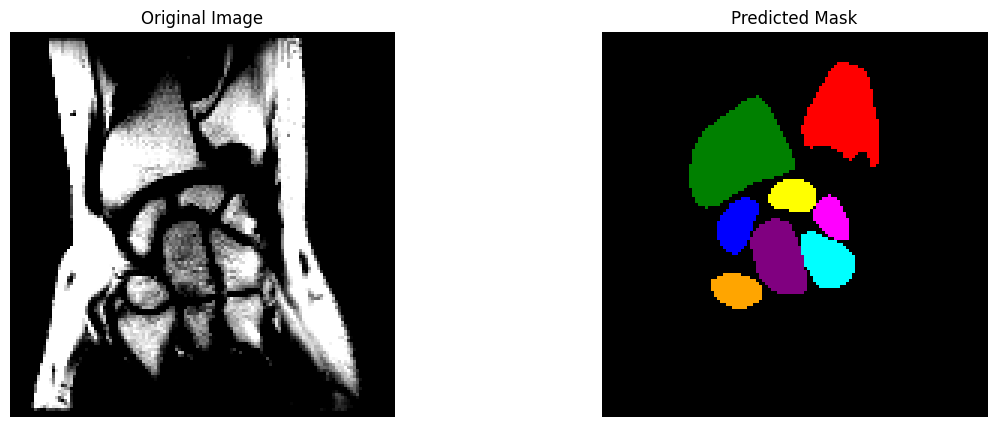

Test output shape: (1, 1, 128, 128, 48)
Unique values in test output: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


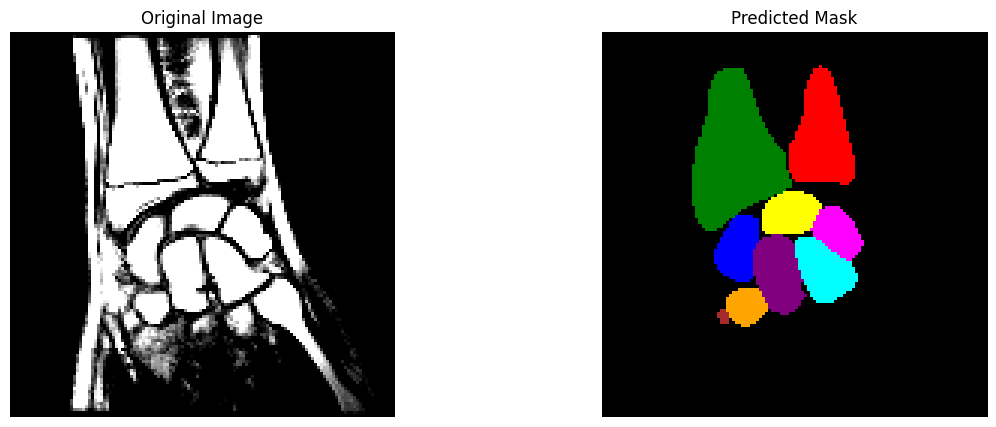

Test output shape: (1, 1, 128, 128, 48)
Unique values in test output: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


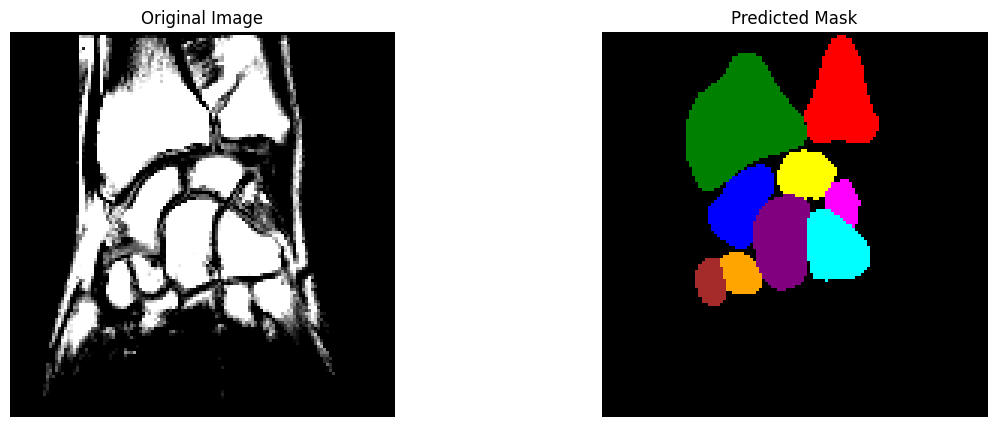

Test output shape: (1, 1, 128, 128, 48)
Unique values in test output: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


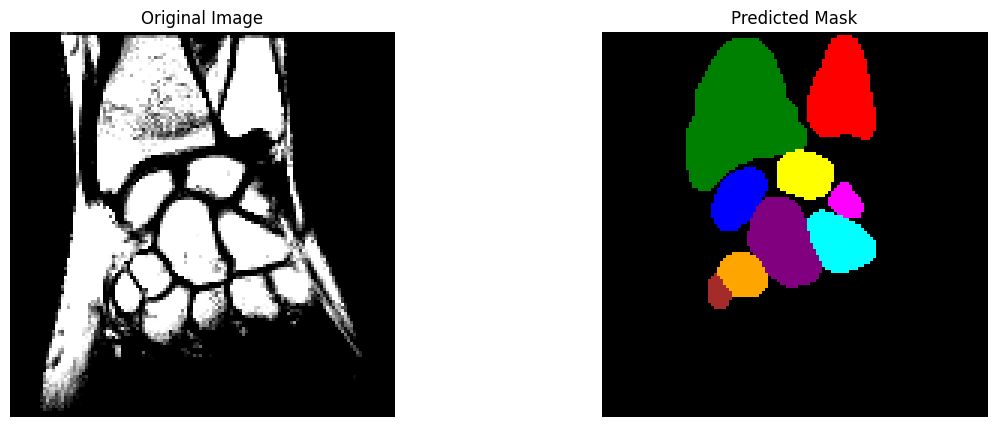

Test output shape: (1, 1, 128, 128, 48)
Unique values in test output: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


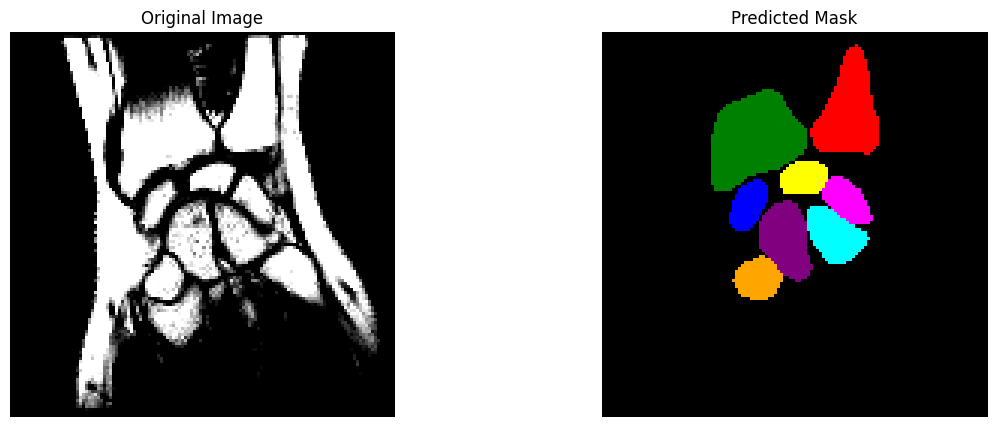

Test output shape: (1, 1, 128, 128, 48)
Unique values in test output: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


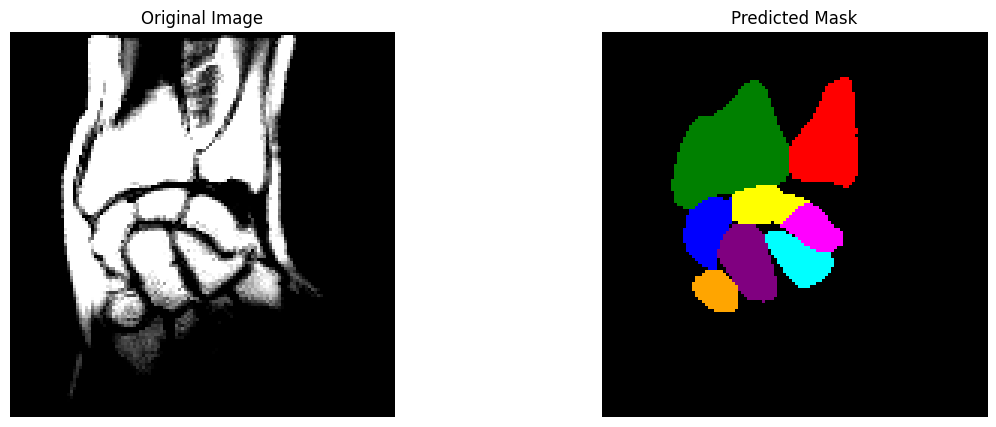

In [32]:
data_dir = '/workspace/data'
output_dir = '/workspace/predicted_masks'  #
os.makedirs(output_dir, exist_ok=True)

test_images = sorted(glob(os.path.join(data_dir, 'imagesTs', '*nii.gz')))
test_labels = sorted(glob(os.path.join(data_dir, 'labelsTs', '*nii.gz')))

test_files = [{"image": img, "label": lbl} for img, lbl in zip(test_images, test_labels)]

# Transformations for inference
test_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    AddChanneld(keys=["image", "label"]),
    NormalizeIntensityd(keys=["image"], nonzero=True, channel_wise=True),
    ScaleIntensityRanged(keys=["image"], a_min=0.0011, a_max=1.01, b_min=0.0, b_max=1.0, clip=True),
    EnsureTyped(keys=["image", "label"]),
    ToTensord(keys=["image", "label"])
])

# Dataset and DataLoader for test data
test_ds = Dataset(data=test_files, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=1)

# Loading the trained models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

segresnet_model = SegResNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=11,
    init_filters=16,
    dropout_prob=0.2,
    norm='batch'
).to(device)
segresnet_model.load_state_dict(torch.load('best_metric_model_segresnet.pth', map_location=device))
segresnet_model.eval()

dynunet_model = DynUNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=11,  # 10 bones + background
    kernel_size=[3, 3, 3, 3],
    strides=[1, 2, 2, 2],
    upsample_kernel_size=[2, 2, 2],
    norm_name="instance",
    deep_supervision=False,
    res_block=True,
).to(device)
dynunet_model.load_state_dict(torch.load('best_metric_model_dyunet.pth', map_location=device))
dynunet_model.eval()

unetr_model = UNETR(
    in_channels=1,
    out_channels=11,  # 10 bones + background
    img_size=(128, 128, 48),
    feature_size=32,
    hidden_size=384,
    mlp_dim=1024,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.1
).to(device)
unetr_model.load_state_dict(torch.load('best_metric_model_unetr.pth', map_location=device))
unetr_model.eval()

# Inference
post_trans = Compose([Activations(softmax=True), AsDiscrete(argmax=True, to_onehot=False)])

# Visualization function with custom colormap
def visualize_results(image, prediction, slice_num, num_classes=11):
    # Creating a colormap with a unique color for each class
    cmap = colors.ListedColormap(['black', 'red', 'green', 'blue', 'yellow', 'magenta', 'cyan', 'orange', 'purple', 'brown', 'pink'])
    bounds = np.linspace(0, num_classes, num_classes + 1)
    norm = colors.BoundaryNorm(bounds, cmap.N)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(image[0, 0, :, :, slice_num], cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Predicted Mask")

    plt.imshow(prediction[0, :, :, slice_num], cmap=cmap, norm=norm)
    plt.axis('off')

    plt.show()

# Running inference, save predicted masks, and visualize results
for i, test_data in enumerate(test_loader):
    test_images = test_data["image"].to(device)
    with torch.no_grad():
        # Ensemble predictions
        segresnet_output = sliding_window_inference(test_images, (128, 128, 48), 4, segresnet_model)
        dynunet_output = sliding_window_inference(test_images, (128, 128, 48), 4, dynunet_model)
        unetr_output = sliding_window_inference(test_images, (128, 128, 48), 4, unetr_model)

        # Averaging the predictions
        combined_output = (segresnet_output + dynunet_output + unetr_output) / 3.0

        # Post-processing the predictions
        test_outputs = [post_trans(i) for i in decollate_batch(combined_output)]

    # Converting predictions to numpy
    test_outputs = torch.stack(test_outputs).cpu().numpy()

    # Debugging: Print statistics of the predictions
    print(f"Test output shape: {test_outputs.shape}")
    print(f"Unique values in test output: {np.unique(test_outputs)}")

    # Saving the predicted mask
    predicted_mask = test_outputs[0]  
    original_image = nib.load(test_files[i]["image"])
    predicted_nifti = nib.Nifti1Image(predicted_mask, original_image.affine, original_image.header)
    nib.save(predicted_nifti, os.path.join(output_dir, f"predicted_mask_{i}.nii.gz"))

    # Visualizing the results
    slice_num = 22  
    visualize_results(test_images.cpu().numpy(), predicted_mask, slice_num)


Test output shape: (1, 1, 128, 128, 48)
Unique values in test output: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


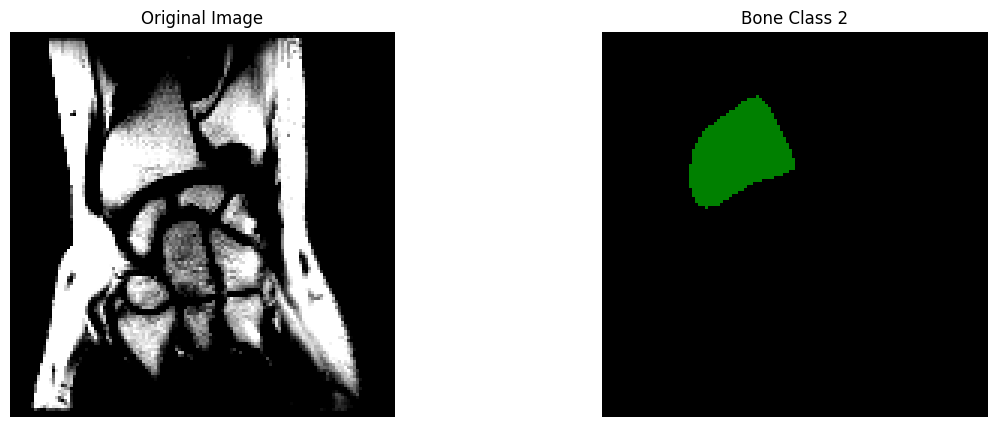

Test output shape: (1, 1, 128, 128, 48)
Unique values in test output: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


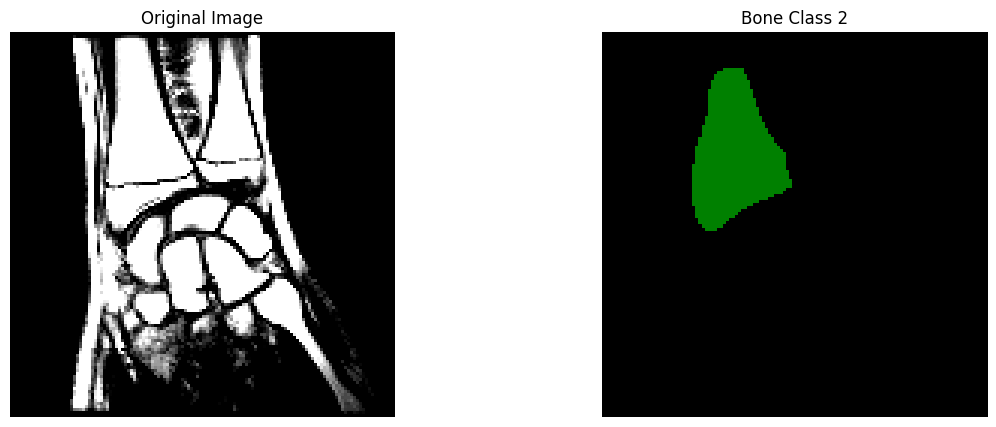

Test output shape: (1, 1, 128, 128, 48)
Unique values in test output: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


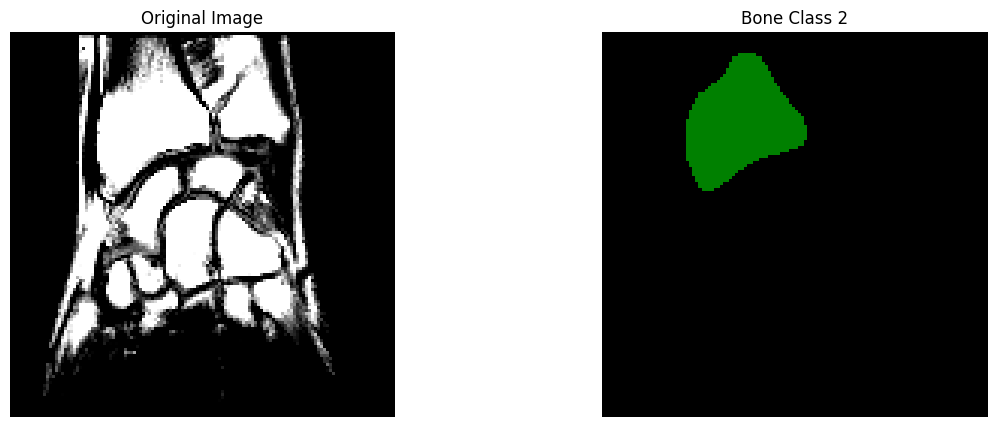

Test output shape: (1, 1, 128, 128, 48)
Unique values in test output: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


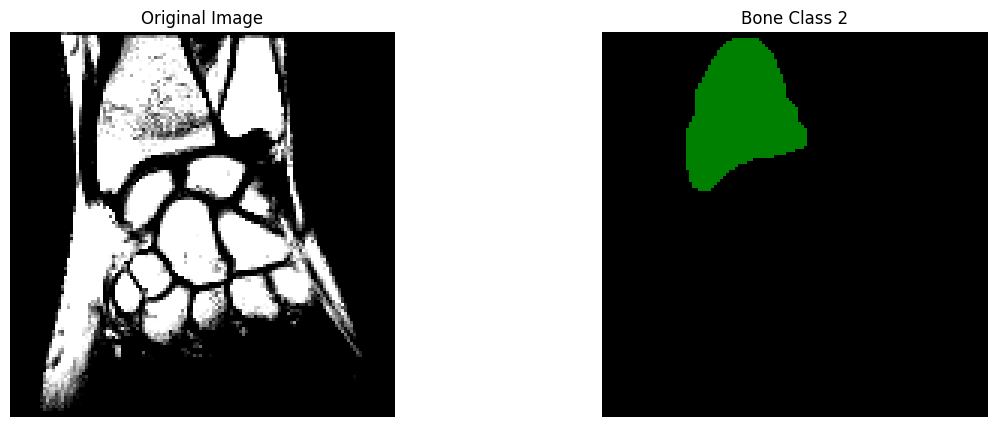

Test output shape: (1, 1, 128, 128, 48)
Unique values in test output: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


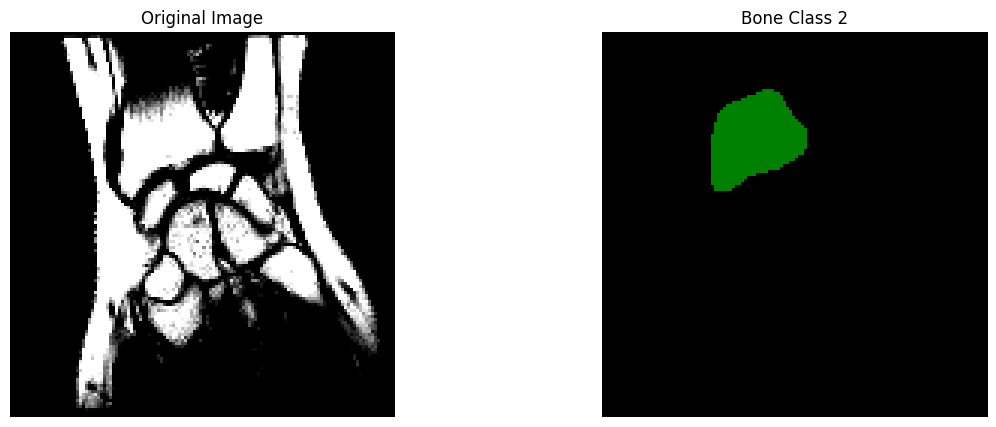

Test output shape: (1, 1, 128, 128, 48)
Unique values in test output: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


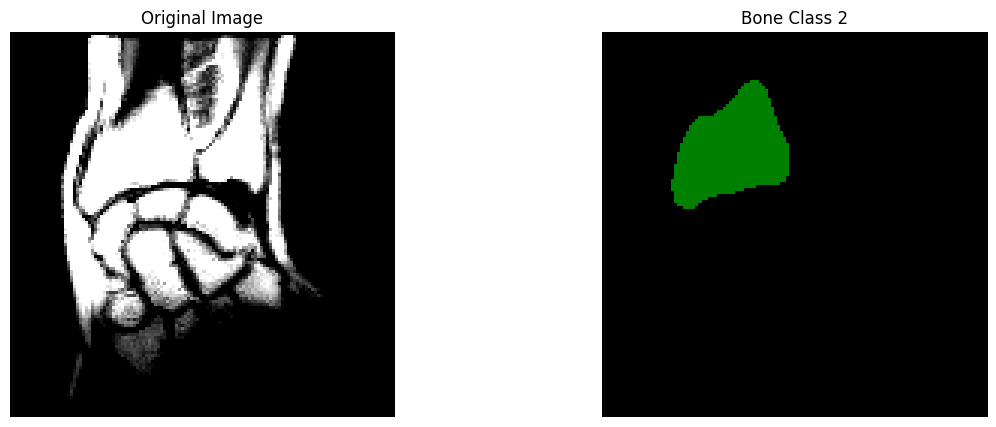

In [31]:

data_dir = '/workspace/data'
output_dir = '/workspace/predicted_masks'  
os.makedirs(output_dir, exist_ok=True)

test_images = sorted(glob(os.path.join(data_dir, 'imagesTs', '*nii.gz')))
test_labels = sorted(glob(os.path.join(data_dir, 'labelsTs', '*nii.gz')))

test_files = [{"image": img, "label": lbl} for img, lbl in zip(test_images, test_labels)]

# Transformations for inference
test_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    AddChanneld(keys=["image", "label"]),
    NormalizeIntensityd(keys=["image"], nonzero=True, channel_wise=True),
    ScaleIntensityRanged(keys=["image"], a_min=0.0011, a_max=1.01, b_min=0.0, b_max=1.0, clip=True),
    EnsureTyped(keys=["image", "label"]),
    ToTensord(keys=["image", "label"])
])

# Dataset and DataLoader for test data
test_ds = Dataset(data=test_files, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=1)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

segresnet_model = SegResNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=11,
    init_filters=16,
    dropout_prob=0.2,
    norm='batch'
).to(device)
segresnet_model.load_state_dict(torch.load('best_metric_model_segresnet.pth', map_location=device))
segresnet_model.eval()

dynunet_model = DynUNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=11,  # 10 bones + background
    kernel_size=[3, 3, 3, 3],
    strides=[1, 2, 2, 2],
    upsample_kernel_size=[2, 2, 2],
    norm_name="instance",
    deep_supervision=False,
    res_block=True,
).to(device)
dynunet_model.load_state_dict(torch.load('best_metric_model_dyunet.pth', map_location=device))
dynunet_model.eval()

unetr_model = UNETR(
    in_channels=1,
    out_channels=11,  # 10 bones + background
    img_size=(128, 128, 48),
    feature_size=32,
    hidden_size=384,
    mlp_dim=1024,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.1
).to(device)
unetr_model.load_state_dict(torch.load('best_metric_model_unetr.pth', map_location=device))
unetr_model.eval()

# Inference
post_trans = Compose([Activations(softmax=True), AsDiscrete(argmax=True, to_onehot=False)])

# Visualization function for specific bone class
def visualize_bone_class(image, prediction, bone_class, slice_num):
    """
    Visualize a specific bone class alongside the original MRI image.
    :param image: The original MRI image.
    :param prediction: The full segmentation mask.
    :param bone_class: The class index of the bone to visualize.
    :param slice_num: The index of the slice to visualize.
    """
    bone_mask = np.where(prediction == bone_class, bone_class, 0)  

    # Creating a colormap with a unique color for each class
    cmap = colors.ListedColormap(['black', 'red', 'green', 'blue', 'yellow', 'magenta', 'cyan', 'orange', 'purple', 'brown', 'pink'])
    bounds = np.linspace(0, 11, 12)
    norm = colors.BoundaryNorm(bounds, cmap.N)

    plt.figure(figsize=(14, 5))

    # Original image
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(image[0, 0, :, :, slice_num], cmap='gray')
    plt.axis('off')

    # Bone class mask
    plt.subplot(1, 2, 2)
    plt.title(f"Bone Class {bone_class}")
    plt.imshow(bone_mask[0, :, :, slice_num], cmap=cmap, norm=norm)
    plt.axis('off')

    plt.show()

# Running inference, save predicted masks, and visualize specific bone class
bone_class_to_visualize = 2  

for i, test_data in enumerate(test_loader):
    test_images = test_data["image"].to(device)
    with torch.no_grad():
        # Ensemble predictions
        segresnet_output = sliding_window_inference(test_images, (128, 128, 48), 4, segresnet_model)
        dynunet_output = sliding_window_inference(test_images, (128, 128, 48), 4, dynunet_model)
        unetr_output = sliding_window_inference(test_images, (128, 128, 48), 4, unetr_model)

        # Averaging the predictions
        combined_output = (segresnet_output + dynunet_output + unetr_output) / 3.0

        # Post-processing the predictions
        test_outputs = [post_trans(i) for i in decollate_batch(combined_output)]

    # Converting predictions to numpy
    test_outputs = torch.stack(test_outputs).cpu().numpy()

    # Debugging: Print statistics of the predictions
    print(f"Test output shape: {test_outputs.shape}")
    print(f"Unique values in test output: {np.unique(test_outputs)}")

    # Saving the predicted mask
    predicted_mask = test_outputs[0]  
    original_image = nib.load(test_files[i]["image"])
    predicted_nifti = nib.Nifti1Image(predicted_mask, original_image.affine, original_image.header)
    nib.save(predicted_nifti, os.path.join(output_dir, f"predicted_mask_{i}.nii.gz"))

    # Visualizing the specific bone class
    slice_num = 22  
    visualize_bone_class(test_images.cpu().numpy(), predicted_mask, bone_class_to_visualize, slice_num)


In [1]:
# Directories
data_dir = '/workspace/data'
output_dir = '/workspace/predicted_masks_ensemble_2'  # Output directory for predicted masks
os.makedirs(output_dir, exist_ok=True)

# File paths
test_images = sorted(glob(os.path.join(data_dir, 'imagesTs', '*.nii.gz')))
test_labels = sorted(glob(os.path.join(data_dir, 'labelsTs', '*.nii.gz')))

test_files = [{"image": img, "label": lbl} for img, lbl in zip(test_images, test_labels)]

# Transformations for inference
test_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    AddChanneld(keys=["image", "label"]),
    NormalizeIntensityd(keys=["image"], nonzero=True, channel_wise=True),
    ScaleIntensityRanged(keys=["image"], a_min=0.0011, a_max=1.01, b_min=0.0, b_max=1.0, clip=True),
    EnsureTyped(keys=["image", "label"]),
    ToTensord(keys=["image", "label"])
])

# Dataset and DataLoader for test data
test_ds = Dataset(data=test_files, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=1)

# Loading the trained models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

segresnet_model = SegResNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=11,
    init_filters=16,
    dropout_prob=0.2,
    norm='batch'
).to(device)
segresnet_model.load_state_dict(torch.load('best_metric_model_segresnet.pth', map_location=device))
segresnet_model.eval()

dynunet_model = DynUNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=11,  # 10 bones + background
    kernel_size=[3, 3, 3, 3],
    strides=[1, 2, 2, 2],
    upsample_kernel_size=[2, 2, 2],
    norm_name="instance",
    deep_supervision=False,
    res_block=True,
).to(device)
dynunet_model.load_state_dict(torch.load('best_metric_model_dyunet.pth', map_location=device))
dynunet_model.eval()

# Inference
post_trans = Compose([Activations(softmax=True), AsDiscrete(argmax=True, to_onehot=False)])

# Running inference and saving predicted masks
for i, test_data in enumerate(test_loader):
    test_images = test_data["image"].to(device)
    with torch.no_grad():
        # Ensemble predictions
        segresnet_output = sliding_window_inference(test_images, (128, 128, 48), 4, segresnet_model)
        dynunet_output = sliding_window_inference(test_images, (128, 128, 48), 4, dynunet_model)

        # Averaging the predictions
        combined_output = (segresnet_output + dynunet_output) / 3.0

        # Post-processing the predictions
        test_outputs = [post_trans(i) for i in decollate_batch(combined_output)]

    # Converting predictions to numpy and removing extra dimensions
    test_outputs = torch.stack(test_outputs).cpu().numpy()
    test_outputs = np.squeeze(test_outputs, axis=0)  # Remove any singleton dimensions
    test_outputs = np.squeeze(test_outputs, axis=0)  # Remove extra channel dimension

    # Debugging: Print statistics of the predictions
    print(f"Test output shape: {test_outputs.shape}")
    print(f"Unique values in test output: {np.unique(test_outputs)}")

    # Saving the predicted mask as a 3D Nifti image
    predicted_mask = test_outputs  # (128, 128, 48)
    original_image = nib.load(test_files[i]["image"])
    output_filename = os.path.basename(test_files[i]["image"]).replace('.nii.gz', '_ensemble.nii.gz')
    predicted_nifti = nib.Nifti1Image(predicted_mask, original_image.affine, original_image.header)
    nib.save(predicted_nifti, os.path.join(output_dir, output_filename))

print("Ensemble inference completed, and combined masks are saved in predicted_mask_ensemble_2 folder.")


/opt/conda/lib/python3.10/site-packages/monai/transforms/post/array.py:176: UserWarning: `to_onehot=True/False` is deprecated, please use `to_onehot=num_classes` instead.
  warnings.warn("`to_onehot=True/False` is deprecated, please use `to_onehot=num_classes` instead.")


Test output shape: (128, 128, 48)
Unique values in test output: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
Test output shape: (128, 128, 48)
Unique values in test output: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
Test output shape: (128, 128, 48)
Unique values in test output: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
Test output shape: (128, 128, 48)
Unique values in test output: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
Test output shape: (128, 128, 48)
Unique values in test output: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
Test output shape: (128, 128, 48)
Unique values in test output: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
Ensemble inference completed, and combined masks are saved in predicted_mask_ensemble_2 folder.
